# 코랩 내 TPU를 사용하여 학습

In [1]:
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
!echo $COLAB_TPU_ADDR

In [3]:
import tensorflow as tf

# TPU gRPC 접근 URI
TPU_PATH = f"grpc://{os.environ['COLAB_TPU_ADDR']}"

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_PATH)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.22.22.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.22.22.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


In [5]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [6]:
from PIL import Image
import os, glob, sys
import numpy as np
from sklearn.model_selection import train_test_split # 섞어줌
from keras.utils import np_utils

In [7]:
# CNN에서 분류한 데이터를 가져온다.

X_train, X_test, y_train, y_test = np.load('/content/drive/MyDrive/git/4_categorical_100.npy', allow_pickle=True)

# 데이터 정규화
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [17]:
# resNet 모델 작성
def model_res():

    # F(X) = F(X) + X
    def indentity_block(X, f, filters):
        
        # 필터 갯수
        F1, F2, F3 = filters

        # X 저장 
        X_shortcut = X

        ### F(X) ###
        # 첫번째 conv layer
        X = Conv2D(F1, (1, 1), strides = (1, 1), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 두번쨰 conv layer
        X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 세번째 conv layer
        X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)

        # F(X) + X
        # 첫번째와 세번째는 1x1이고 두번째는 padding이 same 이므로 shape는 동일하다.
        X = layers.Add()([X, X_shortcut])
        X = layers.Activation('relu')(X)

        return X

    # F(X) = F(X) + G(X) : 숏컷 적용 레이어
    def Conv_Block(X, f, filters, s = 2):
        
        # 필터 갯수
        F1, F2, F3 = filters

        # X 저장
        X_shortcut = X

        ### F(X) ###
        # 첫번째 conv layer
        X = Conv2D(F1, (1, 1), strides = (s, s), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 두번쨰 conv layer
        X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        X = layers.Activation('relu')(X)

        # 세번째 conv layer
        X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid')(X)
        X = layers.BatchNormalization(axis = 3)(X)
        
        ### G(X) ###
        # shortcut layer
        X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding= 'valid')(X_shortcut)   
        X_shortcut = layers.BatchNormalization(axis = 3)(X_shortcut)

        # F(X) + G(X)
        X = layers.Add()([X, X_shortcut])
        X = layers.Activation('relu')(X)

        return X 

    # resNet50 은 다음과 같은 구조를 갖는다.
    # 0. (3,3) 제로 패딩
    # 1. Conv2D 사용. s = 2인 7x7 크기 필터 64개, 배치 정규화, relu 사용, MaxPooling 사용
    # 2. Conv_Block 사용. s = 1인 3x3 크기 필터 64x64x256개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 64x64x256개 사용
    # 3. Conv_Block 사용. s = 2인 3x3 크기 필터 128x128x512개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 128x128x512개 사용
    # 4. Conv_Block 사용. s = 2인 3x3 크기 필터 256x256x1024개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 256x256x1024개 사용
    # 5. Conv_Block 사용. s = 2인 3x3 크기 필터 512x512x2048개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 256x256x1024개 사용
    # 6. AveragePooling 사용. 2x2
    # 7. Dense layer

    input_img = Input((100, 100, 3))

    # 0. (3,3) 제로 패딩
    # 1. Conv2D 사용. s = 2인 7x7 크기 필터 64개, 배치 정규화, relu 사용, MaxPooling 사용
    X = Conv2D(64, (7, 7), strides = (2, 2), padding = "same")(input_img)
    X = layers.BatchNormalization(axis = 3)(X)
    X = layers.Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2, 2))(X)

    # 2. Conv_Block 사용. s = 1인 3x3 크기 필터 64x64x256개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 64x64x256개 사용
    X = Conv_Block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = indentity_block(X, 3, [64, 64, 256])
    X = indentity_block(X, 3, [64, 64, 256])

    # 3. Conv_Block 사용. s = 2인 3x3 크기 필터 128x128x512개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 128x128x512개 사용
    X = Conv_Block(X, 3, [128, 128, 512])
    X = indentity_block(X, 3, [128, 128, 512])
    X = indentity_block(X, 3, [128, 128, 512])

    # 4. Conv_Block 사용. s = 2인 3x3 크기 필터 256x256x1024개 사용
    #    indentity_block 5번 사용. 3x3 크기 필터 256x256x1024개 사용
    X = Conv_Block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])
    X = indentity_block(X, 3, [256, 256, 1024])

    # 5. Conv_Block 사용. s = 2인 3x3 크기 필터 512x512x2048개 사용
    #    indentity_block 2번 사용. 3x3 크기 필터 256x256x1024개 사용
    X = Conv_Block(X, 3, [512, 512, 2048])
    X = indentity_block(X, 3, [512, 512, 2048])
    X = indentity_block(X, 3, [512, 512, 2048])

    # 6. AveragePooling 사용. 2x2
    X = AveragePooling2D(2, 2)(X)

    # 7. Dense layer
    X = Flatten()(X)
    out = Dense(4, activation="softmax")(X)

    model = Model(inputs = input_img, outputs = out)

    return model


In [18]:
model_res().summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_104 (Conv2D)            (None, 50, 50, 64)   9472        ['input_7[0][0]']                
                                                                                                  
 batch_normalization_100 (Batch  (None, 50, 50, 64)  256         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [19]:
with strategy.scope():

    early_stopping = EarlyStopping(monitor='val_loss', patience=10) 

    model = model_res()
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    history = model.fit(X_train, y_train, callbacks=[early_stopping], batch_size=50, validation_data = (X_test,y_test), epochs = 100)

Epoch 1/100
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


182/182 [==============================] - 104s 265ms/step - loss: 1.7404 - accuracy: 0.3615 - val_loss: 1.3680 - val_accuracy: 0.3165
Epoch 2/100
182/182 [==============================] - 9s 48ms/step - loss: 1.1942 - accuracy: 0.4745 - val_loss: 1.6170 - val_accuracy: 0.3343
Epoch 3/100
182/182 [==============================] - 9s 49ms/step - loss: 1.0793 - accuracy: 0.5285 - val_loss: 1.1479 - val_accuracy: 0.5252
Epoch 4/100
182/182 [==============================] - 9s 49ms/step - loss: 0.9379 - accuracy: 0.6058 - val_loss: 1.6304 - val_accuracy: 0.4946
Epoch 5/100
182/182 [==============================] - 10s 53ms/step - loss: 0.8712 - accuracy: 0.6409 - val_loss: 2.4780 - val_accuracy: 0.3323
Epoch 6/100
182/182 [==============================] - 9s 49ms/step - loss: 0.7931 - accuracy: 0.6743 - val_loss: 2.4835 - val_accuracy: 0.4758
Epoch 7/100
182/182 [==============================] - 9s 49ms/step - loss: 0.7537 - accuracy: 0.6940 - val_loss: 1.2885 - val_accuracy: 0.6093


<Figure size 432x288 with 0 Axes>

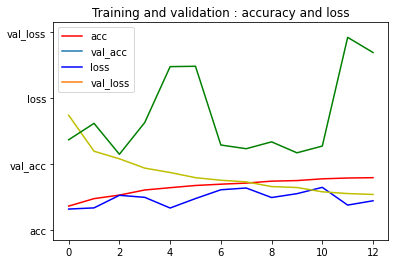

<Figure size 432x288 with 0 Axes>

In [20]:
# 정확도와 loss 차트 그리기
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

# history의 train과 test의 정확도와 loss를 각각 가져온다.
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # 에포크

# 그래프로 표시
plt.plot(epochs, acc, 'r', "acc")
plt.plot(epochs, val_acc, 'b', "val_acc")
plt.plot(epochs, loss, 'y', "loss")
plt.plot(epochs, val_loss, 'g', "val_loss")
plt.legend(['acc','val_acc','loss','val_loss'], loc = 'upper left')

plt.title('Training and validation : accuracy and loss')
plt.figure()